The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.0
14.0
14.0
11.0
12.0
8.0
17.0
11.0
8.0
4.0
11.0
9.0
5.0
11.0
8.0
4.0
8.0
4.0
4.0
-13.0
-13.0
-14.0
-14.0
-13.0
-14.0
-14.0
-13.0
-13.0
-4.0
-12.0
-4.0
-13.0
-4.0
-12.0
-5.0
-12.0
-13.0
-13.0
-13.0
-6.0
-12.0
-12.0
-6.0
-12.0
-4.0
-6.0
-11.0
-6.0
-11.0
-6.0
-11.0
-3.0
-6.0
-11.0
0.0
-4.0
-6.0
-10.0
-4.0
-7.0
-10.0
-5.0
-7.0
-10.0
-3.0
-6.0
-7.0
-9.0
-4.0
-6.0
-7.0
-9.0
-5.0
-7.0
-7.0
-7.0
-6.0
-8.0
-6.0
-7.0
-8.0
-8.0
-5.0
-6.0
-9.0
-7.0
-6.0
-5.0
-8.0
-9.0
-6.0
-5.0
-9.0
-9.0
-6.0
-4.0
-11.0
-9.0
-5.0
-12.0
-9.0
-6.0
-13.0
-9.0
-13.0
-13.0
1.0
2.0
0.0
2.0
0.0
-3.0
2.0
0.0
-3.0
-5.0
2.0
0.0
-3.0
-6.0
2.0
0.0
-4.0
-6.0
-4.0
-7.0
-4.0
-8.0
-49.0
-49.0
-49.0
-48.0
-48.0
-49.0
-48.0
-48.0
-48.0
-47.0
-40.0
-47.0
-40.0
-47.0
-38.0
-47.0
-37.0
-47.0
-38.0
-47.0
-36.0
-46.0
-34.0
-45.0
-35.0
-44.0
-34.0
-43.0
-34.0
-43.0
-35.0
-43.0
-35.0
-42.0
-24.0
-35.0
-42.0
-23.0
-36.0
-42.0
-24.0
-36.0
-42.0
-24.0


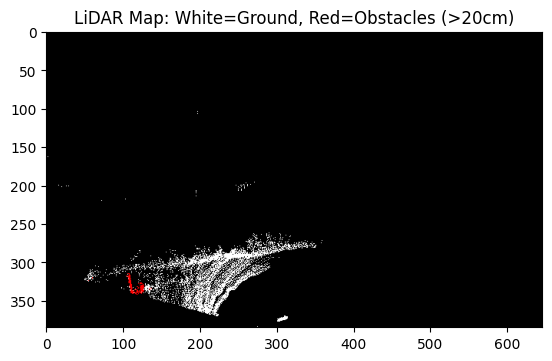

In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np
from pathlib import Path
import open3d as o3d
import cv2
import matplotlib.pyplot as plt

dataset_root = Path.home() / "agrivla/dataset/2024/site1-1"
lidar_path = dataset_root / "lidar" / "fov150" / "03299.ply"

pcd = o3d.io.read_point_cloud(str(lidar_path))
points = np.asarray(pcd.points)

x_min, x_max = points[:, 0].min(), points[:, 0].max()
y_min, y_max = points[:, 1].min(), points[:, 1].max()

resolution = 5
img_height = int((x_max - x_min) / resolution) + 1
img_width = int((y_max - y_min) / resolution) + 1

img = np.zeros((img_height, img_width, 3), dtype=np.uint8)

height_threshold = 40

for point in points:
    x, y, z = point
    img_x = int((x - x_min) / resolution)
    img_y = int((y - y_min) / resolution)
    
    if 0 <= img_x < img_height and 0 <= img_y < img_width:
        if height_threshold < z :
            img[img_x, img_y] = [0, 0, 255]
        elif np.abs(z) < 50:
            print(z)
            img[img_x, img_y] = [255, 255, 255]

img = cv2.flip(img, 0)
img = cv2.flip(img, 1)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('LiDAR Map: White=Ground, Red=Obstacles (>20cm)')
plt.show()

In [54]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2
import open3d as o3d
from visualizer import MapVisualizer

visualizer = MapVisualizer("./test_vis")

frame_ids = ["00000", "00060", "00120"]
robot_positions = [
    np.array([0.0, 0.0], dtype=np.float32),
    np.array([0.0, 0.4], dtype=np.float32),
    np.array([0.0, 0.8], dtype=np.float32)
]
robot_trajectory = [
    np.array([0.0, 0.0], dtype=np.float32),
    np.array([0.0, 0.4], dtype=np.float32),
    np.array([0.0, 0.8], dtype=np.float32)
]

global_map = {}
height_threshold = 0.3

for idx, frame_id in enumerate(frame_ids):
    lidar_path = f"/home/nahyeon/agrivla/dataset/2024/site1-1/lidar/fov150/{frame_id}.ply"
    pcd = o3d.io.read_point_cloud(lidar_path)
    points = np.asarray(pcd.points)
    points = points / 100.0
    transformed = np.zeros_like(points)
    transformed[:, 0] = points[:, 1]
    transformed[:, 1] = points[:, 2]
    transformed[:, 2] = points[:, 0]
    points = transformed
    
    robot_pos = robot_positions[idx]
    
    ground_points = points[points[:, 2] < height_threshold]
    obstacle_points = points[points[:, 2] >= height_threshold]
    
    for p in ground_points:
        local_x = round(p[0], 2)
        local_y = round(p[2], 2)
        global_x = robot_pos[0] + local_x
        global_y = robot_pos[1] + local_y
        key = (round(global_x, 2), round(global_y, 2))
        global_map[key] = 0.2
    
    for p in obstacle_points:
        local_x = round(p[0], 2)
        local_y = round(p[2], 2)
        global_x = robot_pos[0] + local_x
        global_y = robot_pos[1] + local_y
        key = (round(global_x, 2), round(global_y, 2))
        global_map[key] = 0.8
    
    rgb_path = f"/home/nahyeon/agrivla/dataset/2024/site1-1/frame_R/R_{frame_id}.png"
    rgb = cv2.imread(rgb_path)
    
    map_display = visualizer.visualize(
        frame_id,
        rgb,
        global_map=global_map,
        robot_pos=robot_pos,
        robot_trajectory=robot_trajectory[:idx+1],
        lidar_resolution=5
    )
    
    print(f"Frame {frame_id}: Robot at ({robot_pos[0]:.2f}, {robot_pos[1]:.2f}), Map size: {len(global_map)}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Saved: test_vis/frame0000.png
Frame 00000: Robot at (0.00, 0.00), Map size: 147857
Saved: test_vis/frame0060.png
Frame 00060: Robot at (0.00, 0.40), Map size: 159172
Saved: test_vis/frame0120.png
Frame 00120: Robot at (0.00, 0.80), Map size: 171873


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrow
import os
from pathlib import Path
import open3d as o3d


class YawVerification:
    def __init__(self, dataset_root):
        self.dataset_root = Path(dataset_root)
        self.lidar_dir = self.dataset_root / "lidar" / "fov150"
    
    def load_lidar(self, frame_id):
        lidar_path = self.lidar_dir / f"{frame_id}.ply"
        if lidar_path.exists():
            pcd = o3d.io.read_point_cloud(str(lidar_path))
            points = np.asarray(pcd.points)
            points = points / 100.0
            transformed = np.zeros_like(points)
            transformed[:, 0] = -points[:, 1]
            transformed[:, 1] = points[:, 0]
            transformed[:, 2] = points[:, 2]
            return transformed
        return None
    
    def downsample_points(self, points, voxel_size=0.1):
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)
        pcd_down = pcd.voxel_down_sample(voxel_size)
        return np.asarray(pcd_down.points)
    
    def compute_icp(self, source_points, target_points):
        source = o3d.geometry.PointCloud()
        target = o3d.geometry.PointCloud()
        source.points = o3d.utility.Vector3dVector(source_points)
        target.points = o3d.utility.Vector3dVector(target_points)
        
        threshold = 1.0
        trans_init = np.eye(4)
        
        reg = o3d.pipelines.registration.registration_icp(
            source, target, threshold, trans_init,
            o3d.pipelines.registration.TransformationEstimationPointToPoint()
        )
        
        return reg.transformation, reg.fitness, reg.inlier_rmse
    
    def extract_yaw_multiple_methods(self, R):
        methods = {
            'method1_R10_R00': np.arctan2(R[1, 0], R[0, 0]),
            'method2_R01_R11': np.arctan2(-R[0, 1], R[1, 1]),
            'method3_R21_R20': np.arctan2(R[2, 1], R[2, 0]),
            'method4_neg_R10_R00': -np.arctan2(R[1, 0], R[0, 0]),
        }
        return methods
    
    def test_rotation_formula(self):
        print("="*70)
        print("TEST 1: Rotation Formula Verification")
        print("="*70)
        
        test_cases = [
            (0, "No rotation"),
            (np.pi/4, "45° counterclockwise"),
            (np.pi/2, "90° counterclockwise"),
            (np.pi, "180°"),
            (-np.pi/2, "90° clockwise"),
        ]
        
        local_point = np.array([1.0, 0.0])
        
        for yaw, description in test_cases:
            cos_yaw = np.cos(yaw)
            sin_yaw = np.sin(yaw)
            
            rotated_x = cos_yaw * local_point[0] - sin_yaw * local_point[1]
            rotated_y = sin_yaw * local_point[0] + cos_yaw * local_point[1]
            
            print(f"\n{description} (yaw={np.degrees(yaw):.1f}°):")
            print(f"  Local point: ({local_point[0]:.2f}, {local_point[1]:.2f})")
            print(f"  Rotated point: ({rotated_x:.2f}, {rotated_y:.2f})")
            print(f"  Expected: ({np.cos(yaw):.2f}, {np.sin(yaw):.2f})")
            print(f"  Match: {np.allclose([rotated_x, rotated_y], [np.cos(yaw), np.sin(yaw)])}")
    
    def test_local_to_global_transform(self):
        print("\n" + "="*70)
        print("TEST 2: Local to Global Transform")
        print("="*70)
        
        robot_pos = np.array([5.0, 5.0])
        robot_yaw = np.pi / 4
        
        local_points = {
            'front': (0.0, 1.0),
            'back': (0.0, -1.0),
            'right': (1.0, 0.0),
            'left': (-1.0, 0.0),
            'front_right': (1.0, 1.0),
        }
        
        print(f"\nRobot state:")
        print(f"  Position: ({robot_pos[0]:.2f}, {robot_pos[1]:.2f})")
        print(f"  Yaw: {np.degrees(robot_yaw):.1f}°")
        
        cos_yaw = np.cos(robot_yaw)
        sin_yaw = np.sin(robot_yaw)
        
        print(f"\nLocal → Global transformations:")
        for name, (lx, ly) in local_points.items():
            rotated_x = cos_yaw * lx - sin_yaw * ly
            rotated_y = sin_yaw * lx + cos_yaw * ly
            
            global_x = robot_pos[0] + rotated_x
            global_y = robot_pos[1] + rotated_y
            
            print(f"  {name:15s}: local({lx:5.1f}, {ly:5.1f}) → global({global_x:6.2f}, {global_y:6.2f})")
    
    def visualize_transformation_sequence(self, frame_ids):
        print("\n" + "="*70)
        print("TEST 3: Transformation Sequence Visualization")
        print("="*70)
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 16))
        
        point_clouds = []
        for fid in frame_ids:
            pc = self.load_lidar(fid)
            if pc is not None:
                point_clouds.append(self.downsample_points(pc, 0.1))
        
        if len(point_clouds) < 2:
            print("Not enough point clouds loaded")
            return
        
        ax = axes[0, 0]
        ax.scatter(point_clouds[0][:, 0], point_clouds[0][:, 1], s=1, alpha=0.5, label=f'Frame {frame_ids[0]}')
        ax.scatter(point_clouds[1][:, 0], point_clouds[1][:, 1], s=1, alpha=0.5, label=f'Frame {frame_ids[1]}')
        ax.set_xlabel('X (left/right)')
        ax.set_ylabel('Y (back/front)')
        ax.set_title('Raw Point Clouds (Bird\'s Eye View)')
        ax.legend()
        ax.grid(True)
        ax.axis('equal')
        
        T, fitness, rmse = self.compute_icp(point_clouds[1], point_clouds[0])
        
        ax = axes[0, 1]
        ax.text(0.1, 0.9, 'ICP Transformation Matrix:', transform=ax.transAxes, fontsize=12, fontweight='bold')
        ax.text(0.1, 0.7, str(T), transform=ax.transAxes, fontsize=9, family='monospace')
        ax.text(0.1, 0.3, f'Fitness: {fitness:.4f}', transform=ax.transAxes, fontsize=10)
        ax.text(0.1, 0.2, f'RMSE: {rmse:.4f}', transform=ax.transAxes, fontsize=10)
        
        R = T[:3, :3]
        yaw_methods = self.extract_yaw_multiple_methods(R)
        y_pos = 0.1
        for name, yaw in yaw_methods.items():
            ax.text(0.1, y_pos, f'{name}: {np.degrees(yaw):.2f}°', 
                   transform=ax.transAxes, fontsize=9)
            y_pos -= 0.05
        ax.axis('off')
        
        ax = axes[1, 0]
        translation = T[:3, 3]
        ax.arrow(0, 0, translation[0], translation[1], head_width=0.05, head_length=0.05, 
                fc='red', ec='red', linewidth=2)
        ax.plot(0, 0, 'bo', markersize=10, label='Origin')
        ax.plot(translation[0], translation[1], 'ro', markersize=10, label='Translation')
        ax.text(translation[0]/2, translation[1]/2 + 0.1, 
               f'Δx={translation[0]:.3f}m\nΔy={translation[1]:.3f}m',
               fontsize=10, ha='center')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title('Translation Vector (Top-Down)')
        ax.legend()
        ax.grid(True)
        ax.axis('equal')
        
        ax = axes[1, 1]
        robot_positions = [np.array([0.0, 0.0])]
        robot_yaws = [0.0]
        
        for i in range(len(point_clouds) - 1):
            T, _, _ = self.compute_icp(point_clouds[i+1], point_clouds[i])
            R = T[:3, :3]
            yaw = np.arctan2(R[1, 0], R[0, 0])
            
            local_x = T[0, 3]
            local_y = T[1, 3]
            
            cos_yaw = np.cos(robot_yaws[-1])
            sin_yaw = np.sin(robot_yaws[-1])
            
            global_x = cos_yaw * local_x - sin_yaw * local_y
            global_y = sin_yaw * local_x + cos_yaw * local_y
            
            new_pos = robot_positions[-1] + np.array([global_x, global_y])
            new_yaw = robot_yaws[-1] + yaw
            
            robot_positions.append(new_pos)
            robot_yaws.append(new_yaw)
        
        positions = np.array(robot_positions)
        ax.plot(positions[:, 0], positions[:, 1], 'b-o', linewidth=2, markersize=8, label='Trajectory')
        
        for i, (pos, yaw) in enumerate(zip(positions, robot_yaws)):
            arrow_len = 0.5
            dx = arrow_len * np.cos(yaw)
            dy = arrow_len * np.sin(yaw)
            ax.arrow(pos[0], pos[1], dx, dy, head_width=0.15, head_length=0.15,
                    fc='red', ec='red', alpha=0.7)
            ax.text(pos[0] + 0.3, pos[1] + 0.3, f'{i}\n{np.degrees(yaw):.0f}°', fontsize=8)
        
        ax.set_xlabel('Global X')
        ax.set_ylabel('Global Y')
        ax.set_title('Robot Trajectory with Orientations')
        ax.legend()
        ax.grid(True)
        ax.axis('equal')
        
        plt.tight_layout()
        plt.savefig('yaw_verification_test.png', dpi=150, bbox_inches='tight')
        plt.close()
        print("\nVisualization saved: yaw_verification_test.png")
        
        print("\nTrajectory Summary:")
        for i, (pos, yaw) in enumerate(zip(positions, robot_yaws)):
            print(f"  Step {i}: pos=({pos[0]:6.2f}, {pos[1]:6.2f}), yaw={np.degrees(yaw):6.1f}°")
    
    def test_occupancy_rotation(self):
        print("\n" + "="*70)
        print("TEST 4: Occupancy Map Rotation Test")
        print("="*70)
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        local_occupancy = {}
        for x in np.arange(-2, 3, 0.5):
            for y in np.arange(-1, 4, 0.5):
                if y > 0:
                    local_occupancy[(x, y)] = 0.8
        
        test_cases = [
            (0, 0, 0, "Origin, 0°"),
            (0, 0, np.pi/4, "Origin, 45°"),
            (0, 0, np.pi/2, "Origin, 90°"),
            (5, 5, 0, "Pos(5,5), 0°"),
            (5, 5, np.pi/4, "Pos(5,5), 45°"),
            (5, 5, np.pi/2, "Pos(5,5), 90°"),
        ]
        
        for idx, (rx, ry, yaw, title) in enumerate(test_cases):
            ax = axes[idx // 3, idx % 3]
            
            robot_pos = np.array([rx, ry])
            cos_yaw = np.cos(yaw)
            sin_yaw = np.sin(yaw)
            
            global_occupancy = {}
            for (local_x, local_y), value in local_occupancy.items():
                rotated_x = cos_yaw * local_x - sin_yaw * local_y
                rotated_y = sin_yaw * local_x + cos_yaw * local_y
                
                global_x = robot_pos[0] + rotated_x
                global_y = robot_pos[1] + rotated_y
                global_occupancy[(global_x, global_y)] = value
            
            gxs = [k[0] for k in global_occupancy.keys()]
            gys = [k[1] for k in global_occupancy.keys()]
            
            ax.scatter(gxs, gys, c='red', s=20, alpha=0.5, label='Occupancy')
            ax.plot(robot_pos[0], robot_pos[1], 'b*', markersize=20, label='Robot')
            
            arrow_len = 1.5
            dx = arrow_len * np.cos(yaw)
            dy = arrow_len * np.sin(yaw)
            ax.arrow(robot_pos[0], robot_pos[1], dx, dy, 
                    head_width=0.3, head_length=0.3, fc='blue', ec='blue', linewidth=2)
            
            ax.set_xlabel('Global X')
            ax.set_ylabel('Global Y')
            ax.set_title(title)
            ax.legend()
            ax.grid(True)
            ax.axis('equal')
        
        plt.tight_layout()
        plt.savefig('occupancy_rotation_test.png', dpi=150, bbox_inches='tight')
        plt.close()
        print("\nOccupancy rotation visualization saved: occupancy_rotation_test.png")
    
    def run_all_tests(self, frame_ids):
        print("\n" + "#"*70)
        print("YAW AND OCCUPANCY MAP VERIFICATION")
        print("#"*70)
        
        self.test_rotation_formula()
        self.test_local_to_global_transform()
        self.visualize_transformation_sequence(frame_ids)
        self.test_occupancy_rotation()
        
        print("\n" + "#"*70)
        print("All tests complete!")
        print("#"*70)


if __name__ == "__main__":
    dataset_root = os.path.expanduser("~/agrivla/dataset/2024/site1-1")
    
    verifier = YawVerification(dataset_root)
    
    frame_ids = ["00000", "00030", "00060", "00090"]
    
    verifier.run_all_tests(frame_ids)


######################################################################
YAW AND OCCUPANCY MAP VERIFICATION
######################################################################
TEST 1: Rotation Formula Verification

No rotation (yaw=0.0°):
  Local point: (1.00, 0.00)
  Rotated point: (1.00, 0.00)
  Expected: (1.00, 0.00)
  Match: True

45° counterclockwise (yaw=45.0°):
  Local point: (1.00, 0.00)
  Rotated point: (0.71, 0.71)
  Expected: (0.71, 0.71)
  Match: True

90° counterclockwise (yaw=90.0°):
  Local point: (1.00, 0.00)
  Rotated point: (0.00, 1.00)
  Expected: (0.00, 1.00)
  Match: True

180° (yaw=180.0°):
  Local point: (1.00, 0.00)
  Rotated point: (-1.00, 0.00)
  Expected: (-1.00, 0.00)
  Match: True

90° clockwise (yaw=-90.0°):
  Local point: (1.00, 0.00)
  Rotated point: (0.00, -1.00)
  Expected: (0.00, -1.00)
  Match: True

TEST 2: Local to Global Transform

Robot state:
  Position: (5.00, 5.00)
  Yaw: 45.0°

Local → Global transformations:
  front          : local(  0.0,